# LSTM

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader, random_split
# local
from analytics.gear_vibration.data_loader import load_data
from analytics.utils import log_metrics_mlflow
from analytics.gear_vibration.models import LstmClassifier
from analytics.gear_vibration.model_trainer import ModelTrainer
from analytics.gear_vibration.data_loader import GearVibrationLstmDataset
from analytics.gear_vibration.analysis import sliding_window

In [2]:
data, df = load_data(path=Path('./data/gear_vibration'))

In [ ]:
VERSION = '0.0.5'
CONFIG = {'window_size': 256, 'step_size': 128, 'version': VERSION, 'normalized': True, 'batch_size': 128}
mlflow_expiriment = 'gear_vibration'
model_name = f'lstm_w_{CONFIG["window_size"]}'

In [4]:
df_window, df_labels = sliding_window(df=df, window_size=CONFIG['window_size'], step_size=CONFIG['step_size'], features=['sensor1', 'sensor2'])
labels, fault_code = pd.factorize(df_labels['fault'])
mean = df_window.mean(axis=(0, 1))
std = df_window.std(axis=(0, 1))
df_window_norm = (df_window - mean) / std

In [5]:
dataset = GearVibrationLstmDataset(features=df_window_norm, labels=labels)
lstm_classifier = LstmClassifier(input_size=df_window_norm.shape[2],
                                 hidden_size=32,
                                 num_layers=2,
                                 out_features=len(np.unique(labels)))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.001, weight_decay=1e-3)
train, validate = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size=CONFIG['batch_size'], shuffle=False)
validate_loader = DataLoader(validate, batch_size=CONFIG['batch_size'], shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
num_epochs = 200
scheduler = StepLR(optimizer, step_size=30, gamma=0.3)
summary(lstm_classifier.to(device), input_size=(CONFIG['batch_size'], df_window_norm.shape[1], df_window_norm.shape[2]))  # yapf: disable, (batch, seq_len, features)

Using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
LstmClassifier                           [128, 6]                  --
├─LSTM: 1-1                              [128, 256, 64]            34,304
├─Dropout: 1-2                           [128, 64]                 --
├─Linear: 1-3                            [128, 6]                  390
Total params: 34,694
Trainable params: 34,694
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.12
Input size (MB): 0.26
Forward/backward pass size (MB): 16.78
Params size (MB): 0.14
Estimated Total Size (MB): 17.18

In [6]:
trainer = ModelTrainer(
  model=lstm_classifier,
  model_name=model_name,
  criterion=criterion,
  optimizer=optimizer,
  train_loader=train_loader,
  val_loader=validate_loader,
  num_epochs=num_epochs,
  device=device,
  scheduler=scheduler,
  patience=30,
  version=VERSION,
  config=CONFIG,
  mlflow_url='http://localhost:5011',
  mlflow_expiriment=mlflow_expiriment,
)

In [7]:
model = trainer.train()

Epoch [1/200], Training Loss: 1.7887, Validation Loss: 1.7818, Training Accuracy: 18.23%, Validation Accuracy: 25.78%
Epoch [2/200], Training Loss: 1.6686, Validation Loss: 1.5482, Training Accuracy: 29.81%, Validation Accuracy: 33.12%
Epoch [3/200], Training Loss: 1.5362, Validation Loss: 1.4877, Training Accuracy: 31.16%, Validation Accuracy: 35.61%
Epoch [4/200], Training Loss: 1.4526, Validation Loss: 1.4181, Training Accuracy: 35.72%, Validation Accuracy: 34.54%
Epoch [5/200], Training Loss: 1.4353, Validation Loss: 1.3979, Training Accuracy: 36.15%, Validation Accuracy: 36.40%
Epoch [6/200], Training Loss: 1.3923, Validation Loss: 1.3305, Training Accuracy: 37.00%, Validation Accuracy: 43.73%
Epoch [7/200], Training Loss: 1.3498, Validation Loss: 1.3239, Training Accuracy: 38.39%, Validation Accuracy: 41.17%
Epoch [8/200], Training Loss: 1.3481, Validation Loss: 1.3311, Training Accuracy: 38.39%, Validation Accuracy: 46.30%
Epoch [9/200], Training Loss: 1.3229, Validation Loss: 1

2025/05/27 15:53:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/27 15:53:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'lstm_w_256'.
2025/05/27 15:53:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lstm_w_256, version 1


🏃 View run lstm_w_256 at: http://localhost:5011/#/experiments/2/runs/0697e983a8364640a9997b7af5043277
🧪 View experiment at: http://localhost:5011/#/experiments/2


Created version '1' of model 'lstm_w_256'.


🏃 View run lstm_w_256 at: http://localhost:5011/#/experiments/2/runs/0697e983a8364640a9997b7af5043277
🧪 View experiment at: http://localhost:5011/#/experiments/2
accuracy: 0.4302
precision_macro: 0.4229
recall_macro: 0.4277
f1_macro: 0.3733
precision_weighted: 0.4216
recall_weighted: 0.4302
f1_weighted: 0.3738


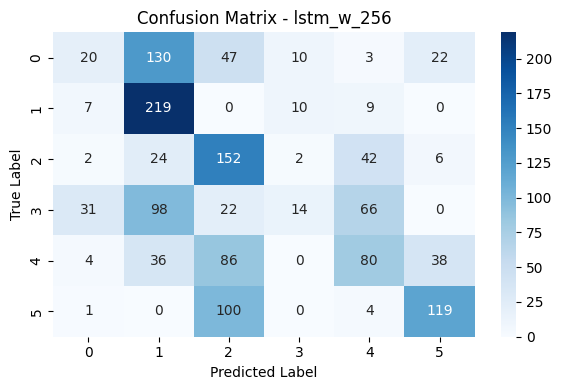

In [8]:
model.eval()
all_preds = []
all_labels = []
for X_batch, y_batch in validate_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    model = model.to(device)
    outputs = model(X_batch)
    preds = torch.argmax(outputs, dim=1)
    all_preds.append(preds.cpu().numpy())
    all_labels.append(y_batch.cpu().numpy())
y_pred = np.concatenate(all_preds)
y_test = np.concatenate(all_labels)
metrics = log_metrics_mlflow(y_test, y_pred, model_name=model_name, run_id=trainer.get_tmp_run_id())
for k, v in metrics.items():
    print(f'{k}: {v:.4f}')
